In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import cm, colors

In [2]:
data_dir = '/Volumes/Aidan_NYGC/mouse_colon/coexpression_analysis/'
mcp_dir = os.path.join(data_dir, 'mcca_spotlight_phenomaj_ENSmarkers2_l2_5pct_panhvgs_6m-2yr')
beta_dir = os.path.join(data_dir, 'beta_matrices_spotlight_phenomaj_ENSmarkers2_l2_5pct_newnames')

In [3]:
t_ordered = ['0d', '1w', '2w', '3w', '4w', '6w', '8w', '12w', '6m', '1yr', '2yr']
conds_ordered = np.concatenate([['%s BL6WT.Proximal' % t, '%s BL6WT.Middle' % t, '%s BL6WT.Distal' % t] for t in t_ordered])
    
# Plot activity of MCPs over time, separated by colon region
def mcp_activity_lineplot2(celltypes, mcp_activities, mcp_list=None, color=None):
    '''
    Parameters:
    ----------
    celltypes: iterable of str
        list of celltypes in current spatial niche.
    mcp_activities: iterable of DataFrame
        one (conditions, mcps) DataFrame for each celltype containing the activity of each
        MCP signal in each cell type in each condition (age+region).
    mcp_list: iterable of str
        list of MCPs to include in plot. Defaults to all.
    ylim: tuple
        set a single (ymin, ymax) for all MCP activity plots, and turn off all y-axis labels but leftmost.
    
    Returns:
    -------
    fig, ax: handles for pyplot figure and axes, respectively
    
    '''
    if mcp_list is None:
        mcp_list = mcp_activities[0].columns
    n_mcps = len(mcp_list)
    n_ctypes = len(celltypes)
    n_times = len([x for x in mcp_activities[0].index if x.endswith('Proximal')])

    plt.rcParams.update({'font.size': 12})

    fig, ax = plt.subplots(1, 3, figsize=(n_times + (n_mcps//4+1), 3), constrained_layout=True)
    
    t_labels = None
    ymin, ymax = 0, 0
    
    for i,mcp in enumerate(mcp_list):
        for j, reg in enumerate(['Proximal', 'Middle', 'Distal']):
            conds_reg = [x for x in mcp_activities[i].index if x.endswith(reg)]
                        
            # Ensure time points are ordered the same across regions
            t_vec = [x.split('.')[0] for x in conds_reg]
            if t_labels is None:
                t_labels = t_vec
            else:
                assert t_labels == t_vec
            
            cell_signals = []
            for c, ctype in enumerate(celltypes):
                cell_signals.append(mcp_activities[c].loc[conds_reg, mcp].values)
            cell_signals = np.array(cell_signals)
            
            # Plot one signal for each MCP, averaged across all cell types.
            ax[j].plot(cell_signals.mean(0), label=mcp, c=color)
            ax[j].set_xticks(range(len(t_labels)))
            ax[j].set_xticklabels(t_labels)
            ax[j].set_xlabel('Age')
            ax[j].set_title(reg)
    
            if np.min(cell_signals.mean(0)) < ymin:
                ymin = np.min(cell_signals.mean(0))
            if np.max(cell_signals.mean(0)) > ymax:
                ymax = np.max(cell_signals.mean(0))
        
    for j in range(3):
        ax[j].set_ylim((ymin, ymax))
        if j > 0:
            ax[j].set_yticks([])
    
    ax[0].set_ylabel("Mean MCP activity")
    ax[-1].legend(loc='lower left', bbox_to_anchor=(1.0,0.0), ncol=n_mcps//4+1)
    
    return fig, ax

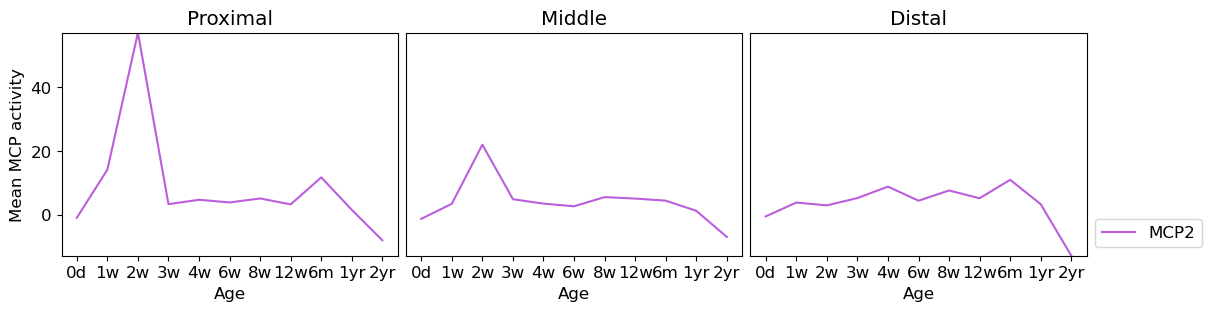

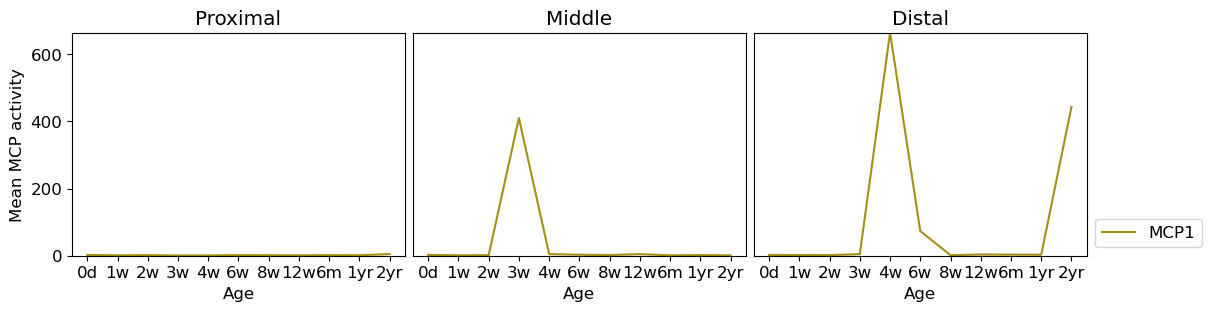

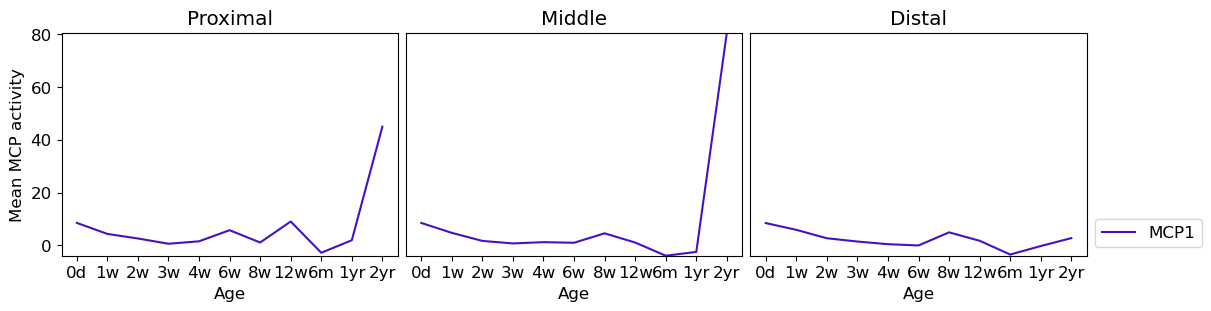

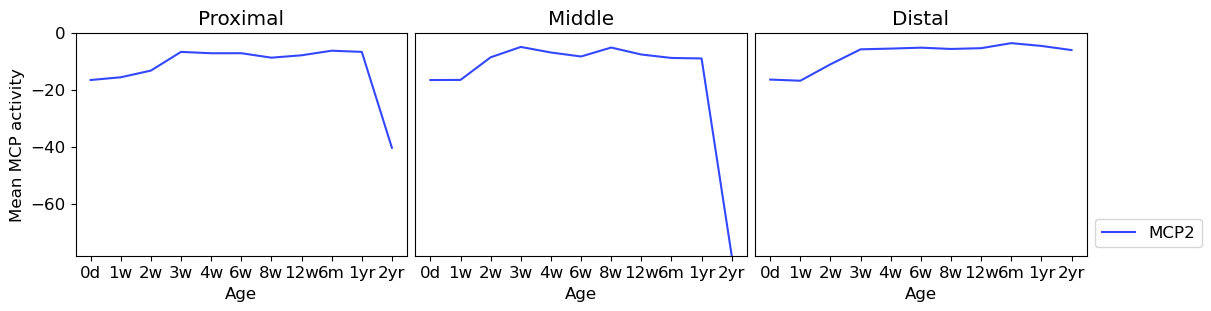

In [17]:
plot_dir = 'fig4_v2'

mroi_mcp_pairs = [
    ('crypt_apex', 'MCP2', np.array((187, 94, 219))/255),
    ('crypt_mid', 'MCP1', np.array((163, 144, 23))/255),
    ('crypt_base', 'MCP1', np.array((71, 16, 200))/255),
    ('sub-crypt', 'MCP2', np.array((51, 71, 255))/255)
    ]
    
for mroi, mcp, color in mroi_mcp_pairs:
    subdir = os.path.join(mcp_dir, mroi)
    mcp_files = glob.glob(os.path.join(subdir, 'mcp_*.csv'))
    
    celltypes, mcp_activities = [], []
    for fh in mcp_files:
        ct = Path(fh).stem.split('_')[1]
        celltypes.append(ct)
    
        df = pd.read_csv(fh, index_col=0)
        df.index = [x[1:] if x.startswith('X') else x for x in df.index.values]
    
        wt_file = fh.replace('mcp', 'ws')
        df_wts = pd.read_csv(wt_file, index_col=0)
    
        beta_file = os.path.join(beta_dir, mroi, 'beta_means_%s.csv' % ct)
        df_beta = pd.read_csv(beta_file, index_col=0)
        df_beta = df_beta.loc[df_wts.index.values, conds_ordered]  # Ensure same genes, same order
        df_beta = np.exp(df_beta)                                  # Transform to counts space
        df_beta.columns = [x.replace(' ','.') for x in df_beta.columns]

        mcp_activity = np.dot(df_beta.T, df_wts)
        df_reconst = pd.DataFrame(mcp_activity, index=df_beta.columns, columns=df_wts.columns)
        mcp_activities.append(df_reconst)

    fig, ax = mcp_activity_lineplot2(celltypes, mcp_activities, mcp_list=[mcp], color=color)
    plt.savefig(os.path.join(plot_dir, 'MCP_activity_%s.svg' % mroi))

In [15]:
np.dot(df_beta.T, df_wts) / df_wts.sum(axis=0).values[None, :]

array([[ 1.23324761e+00,  1.04746735e+00,  1.79962737e+00,
         1.12237034e+00,  1.49289468e+00,  2.47915004e+00,
         1.53542259e+00,  8.92391672e+00,  3.57279706e+00],
       [ 1.24555204e+00,  1.03352579e+00,  1.79532654e+00,
         1.09861557e+00,  1.50397201e+00,  2.53254018e+00,
         1.48876493e+00,  7.57552285e+00,  3.53631940e+00],
       [ 1.24116493e+00,  1.04583175e+00,  1.69692419e+00,
         1.11773552e+00,  1.51327777e+00,  2.42782916e+00,
         1.47795167e+00,  7.89085735e+00,  3.63870003e+00],
       [ 1.24080850e+00,  1.06835081e+00,  1.68652944e+00,
         1.12174118e+00,  1.49533993e+00,  2.47137459e+00,
         1.53135313e+00,  8.43033715e+00,  3.41377764e+00],
       [ 1.22463978e+00,  1.06473200e+00,  1.57325461e+00,
         1.08763533e+00,  1.47642379e+00,  2.45078068e+00,
         1.52663201e+00,  8.55236144e+00,  3.44045021e+00],
       [ 1.24054660e+00,  1.05413739e+00,  1.65489843e+00,
         1.11866021e+00,  1.47625944e+00,  2.475523